# Analyzing Divvy CycleSahre in Chicago

### Description

The reason why the sharing economy can be born is, essentially speaking, to make life more convenient. There are two prerequisites for judging whether a shared economic project can be succeed. One is whether it is suitable for the market, and the other is whether it is needed by people.

It is obviously that the shared bicycle project satisfies these two prerequisites, followed by the demand. There are also many reasons for the users why they choose sharing a bicycle, such as exercising, saving time. 

### Goal

Divvy, a bicycle sharing system, was launched on June 28, 2013 with 750 bikes at 75 stations. It had since expanded to 580 stations (in 2016), making it the largest bike share system in North America in area covered.

Nevertheless, the fast-rising industry of shared bicycles has many problems to be solved, such as asy to recharge but difficult to refund, selection of the company and plan, geographical and time limitations.

Therefore, in order to maximize the benefits and defeat other companies, it is necessary to fully understand the use of shared bicycles by different users, and summarize the different usage habits of different people to set up a more reasonable charging system and the geographical distribution of the stations.

1. When do the users ride?
2. Where do the users go?
3. Which stations are most popular?
4. What days of week are the most rides taken on?


### Downloading Dataset

Start by downloading the data which can do by uncommenting the following commands. The downloaded files will be automaticly classificated into proper folders.

OR can download the data folder via the link below:
- https://www.dropbox.com/sh/ni9k6jxs5r7czoj/AACmKexa2o54sUmjBWZJWWika?dl=0
- https://www.dropbox.com/sh/gae9shx0ykhy4la/AAABMfN4TBpl0sKpn_zv_5ura?dl=0

In [1]:
# import GetData  # local GetData.py file
# GetData.main() 

| File Name | Available Formats |
| ------------- |:-------------:|
| GetData | .py 4KB|
| Divvy_Stations_2017_Q1Q2 | .csv (56KB) |
| Divvy_Stations_2017_Q3Q4 | .csv (46KB) |
| Divvy_Trips_2017_Q1 | .csv (68MB) |
| Divvy_Trips_2017_Q2 | .csv (174.3MB) |
| Divvy_Trips_2017_Q3 | .csv (249.8 MB) |
| Divvy_Trips_2017_Q4 | .csv (85.9 MB) |


Next some standard Python package are needed to imports:

In [8]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

import folium
import pyecharts
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import HeatMap, MarkerCluster

Load Station data and basic setting with Pandas:

In [9]:
""" Read Station Data into Dataframe """
path = "Station_CSV/"
file_list = [file for file in os.listdir(path)]

Station_df = pd.DataFrame()
columns = ["ID", "Name", "City", "Latitude", "Longitude", "Dpcapacity", "OnlineDate"]

for file in file_list:
    chunks = pd.read_csv(path + file)  # read file
    Station_df = pd.concat([Station_df, chunks], 
                           axis=0, 
                           ignore_index=True, 
                           sort=False).dropna(axis=1)
    
Station_df.columns = columns
Station_df = Station_df[columns[0:-1]].drop_duplicates()

latAvg = np.mean([min(Station_df.Latitude), max(Station_df.Latitude)])
lonAvg = np.mean([min(Station_df.Longitude), max(Station_df.Longitude)])

Station_df.head()

,ID,Name,City,Latitude,Longitude,Dpcapacity
0,2,Buckingham Fountain,Chicago,41.876393,-87.620328,27
1,3,Shedd Aquarium,Chicago,41.867226,-87.615355,55
2,4,Burnham Harbor,Chicago,41.856268,-87.613348,23
3,5,State St & Harrison St,Chicago,41.874053,-87.627716,23
4,6,Dusable Harbor,Chicago,41.885041,-87.612794,39


In [3]:
Station_df.tail()

,ID,Name,City,Latitude,Longitude,Dpcapacity
1136,17,Wood St & Division St,Chicago,41.903320,-87.672730,15
1142,413,Woodlawn Ave & Lake Park Ave,Chicago,41.814093,-87.597005,15
1145,602,Central St & Girard Ave,Evanston,42.063999,-87.685962,15
1155,617,East Ave & Garfield St,Oak Park,41.871312,-87.788938,19
1166,613,Wisconsin Ave & Madison St,Oak Park,41.879837,-87.802240,11


In [4]:
Station_df.dtypes

ID              int64
Name           object
City           object
Latitude      float64
Longitude     float64
Dpcapacity      int64
dtype: object

Get some basic information on the Station_df Dataframe:

In [5]:
Station_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793 entries, 0 to 1166
Data columns (total 6 columns):
ID            793 non-null int64
Name          793 non-null object
City          793 non-null object
Latitude      793 non-null float64
Longitude     793 non-null float64
Dpcapacity    793 non-null int64
dtypes: float64(2), int64(2), object(2)
memory usage: 43.4+ KB


No missing values in Station_df dataset.
Each row of the dataset is a station with numbers of docks. by a single person, and the data contains over 793 rows.

Load Trip data and basic settings with Pandas:

In [6]:
""" Read Trip csv data into Dataframe """
path = "Trip_CSV/"

Years = ["2017"]
file_list = [name for yr in Years for name in os.listdir(path) if yr in name]
TripDataset = pd.DataFrame()
col_title = ["TripID", "StartTime", "StopTime", "BikeID", 
             "TripDuration", "FromStationID", "FromStation", "ToStationID", "ToStation", 
             "UserType", "Gender", "BirthYear"]

chunkSize = 100000
for i in range(len(file_list)):
    chunks = pd.read_csv(path + file_list[i], chunksize=chunkSize)  # read file

    for rawdata in chunks:                                                          
        rawdata.columns = col_title
        rawdata.StartTime = pd.to_datetime(rawdata.StartTime)
        rawdata.StopTime = pd.to_datetime(rawdata.StopTime)

        TripDataset = pd.concat([TripDataset, rawdata], 
                                axis=0, 
                                ignore_index=True, 
                                sort="True")
        
TripDataset = TripDataset[TripDataset.UserType!="Dependent"]

TripDataset.head()

,BikeID,BirthYear,FromStation,FromStationID,Gender,StartTime,StopTime,ToStation,ToStationID,TripDuration,TripID,UserType
0,3304,1988.0,Claremont Ave & Hirsch St,159,Male,2017-12-31 23:58:00,2018-01-01 00:03:00,Damen Ave & Pierce Ave,69,284,17536701,Subscriber
1,5975,NaN,Mies van der Rohe Way & Chestnut St,145,NaN,2017-12-31 23:54:00,2018-01-01 00:18:00,Mies van der Rohe Way & Chestnut St,145,1402,17536700,Customer
2,4906,NaN,Mies van der Rohe Way & Chestnut St,145,NaN,2017-12-31 23:54:00,2018-01-01 00:18:00,Mies van der Rohe Way & Chestnut St,145,1441,17536699,Customer
3,5667,1963.0,Clark St & Wrightwood Ave,340,Male,2017-12-31 23:48:00,2017-12-31 23:53:00,Sedgwick St & Webster Ave,143,315,17536698,Subscriber
4,5353,1977.0,Sheridan Rd & Irving Park Rd,240,Male,2017-12-31 23:42:00,2017-12-31 23:47:00,Clarendon Ave & Junior Ter,245,272,17536697,Subscriber


In [7]:
TripDataset.tail()

,BikeID,BirthYear,FromStation,FromStationID,Gender,StartTime,StopTime,ToStation,ToStationID,TripDuration,TripID,UserType
3829009,1796,1960.0,Broadway & Belmont Ave,296,Male,2017-04-01 00:06:30,2017-04-01 00:11:56,Pine Grove Ave & Waveland Ave,232,326,13518910,Subscriber
3829010,22,1979.0,Wabash Ave & Grand Ave,199,Male,2017-04-01 00:06:00,2017-04-01 00:20:53,Clinton St & Tilden St,68,893,13518909,Subscriber
3829011,1296,1993.0,Desplaines St & Kinzie St,56,Male,2017-04-01 00:04:13,2017-04-01 00:19:20,Damen Ave & Pierce Ave,69,907,13518908,Subscriber
3829012,2695,1986.0,Halsted St & Diversey Pkwy,332,Male,2017-04-01 00:03:08,2017-04-01 00:08:24,Racine Ave & Belmont Ave,226,316,13518907,Subscriber
3829013,4596,1987.0,Michigan Ave & Lake St,52,Male,2017-04-01 00:01:35,2017-04-01 00:14:30,Michigan Ave & Jackson Blvd,284,775,13518906,Subscriber


View the data types of each column:

In [10]:
TripDataset.dtypes

BikeID                    int64
BirthYear               float64
FromStation              object
FromStationID             int64
Gender                   object
StartTime        datetime64[ns]
StopTime         datetime64[ns]
ToStation                object
ToStationID               int64
TripDuration              int64
TripID                    int64
UserType                 object
dtype: object

Get some basic information on the TripDataset DataFRame:

In [11]:
TripDataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3829007 entries, 0 to 3829013
Data columns (total 12 columns):
BikeID           int64
BirthYear        float64
FromStation      object
FromStationID    int64
Gender           object
StartTime        datetime64[ns]
StopTime         datetime64[ns]
ToStation        object
ToStationID      int64
TripDuration     int64
TripID           int64
UserType         object
dtypes: datetime64[ns](2), float64(1), int64(5), object(4)
memory usage: 379.8+ MB


Each row of this TripDataset dataset is a single ride by a single person.

Generate various descriptive stations on the TripDataset DataFrame:

In [12]:
TripDataset.describe()

,BikeID,BirthYear,FromStationID,ToStationID,TripDuration,TripID
count,3.829007e+06,2.992249e+06,3.829007e+06,3.829007e+06,3.829007e+06,3.829007e+06
mean,3.425115e+03,1.981586e+03,1.803509e+02,1.805160e+02,9.556342e+02,1.527218e+07
std,1.861237e+03,1.088279e+01,1.328195e+02,1.329274e+02,1.569453e+03,1.302949e+06
min,1.000000e+00,1.899000e+03,2.000000e+00,2.000000e+00,6.000000e+01,1.297923e+07
25%,1.803000e+03,1.976000e+03,7.400000e+01,7.400000e+01,4.020000e+02,1.416006e+07
50%,3.583000e+03,1.985000e+03,1.560000e+02,1.560000e+02,6.860000e+02,1.527486e+07
75%,5.063000e+03,1.990000e+03,2.680000e+02,2.680000e+02,1.149000e+03,1.639615e+07
max,6.471000e+03,2.017000e+03,6.260000e+02,6.260000e+02,8.633800e+04,1.753670e+07


### User Type

Tipically, let's find the ratio of different group of users in order to understand their behaviors.

In [24]:
# Pie Chart (interactive): 
# Membership Percentage and Gender Percentage


genderCount = pd.value_counts(TripDataset.Gender)
gender_labels = ['Male', 'Female']
gender_sizes = genderCount.values

userCount = pd.value_counts(TripDataset.UserType)
user_labels = ['Subscriber', 'Customer']
user_sizes = userCount.values

t1 = "Membership: Female-Male Ratio"
t2 = "UserType: Customer-Subscriber Ratio"

pie = pyecharts.Pie("{}{:32}{}".format(t2, '', t1), title_pos='center', width=900)

pie.add("User", user_labels, user_sizes, center=[25,50], radius=[45,65],
        rosetype='radius',is_legend_show=False, is_label_show=True
       )
pie.add("Gender", gender_labels, gender_sizes, center=[75,50], radius=[45,65],
        rosetype='radius',is_legend_show=False, is_label_show=True,
        subtitle=t1
       )
pie.render("percentage.html")
pie

**[<font color=red>Click to see the Membership Percentage and Gender Percentage</font>](percentage.html)**

UserType: Customer-Subscriber Ratio:
- 'Customer': The total proportion of the one-off user is 21.86%
- 'Subscriber': The total proportion of the registered user is 78.14%

Membership: Female-Male Ratio (Only annual subscribers have gender information):
- ‘Female': The proportion over subscriber of the female user: 24.95%
- 'Male': The proportion over subscriber of the male user: 75.05%

In general, the majority of users are subscribers, and the proportion of subscriber is dominated by male.

Combine the pie charts above displays more intuitive of the proportion of overall users.

In [13]:
def Rate(portion, total):
    """ Calculate the percentage """
    return round(100 * (portion / total), 2)

In [14]:
colors = {2: ["lightblue", "lightcoral"], 1: ["gold", "plum"]}

def Sunburst(nodes, ratio, total=np.pi * 2, offset=0, level=0, ax=None):
    """ Nested Doughnut Plot """

    ax = ax or plt.subplot(111, projection='polar')

    if level == 0 and len(nodes) == 1:
        label, value, subnodes = nodes[0]
        ax.bar([0], [0.5], [np.pi * 2], color='white')
        Sunburst(subnodes, ratio, total=value, level=level + 1, ax=ax)
    
    elif nodes:
        d = np.pi * 2 / total
        labels, widths = [], []
        local_offset = offset

        for label, value, subnodes in nodes:
            labels.append(str(label) + '\n' + ratio[label] + '%')
            widths.append(value * d)
            Sunburst(subnodes, ratio, total=total, offset=local_offset, 
                     level=level + 1, ax=ax)
            local_offset += value

        values = np.cumsum([offset * d] + widths[:-1])
        heights = [1] * len(nodes)
        bottoms = np.zeros(len(nodes)) + level - 0.5

        rects = ax.bar(values, heights, widths, bottoms, color=colors[level], 
                       linewidth=1.2, edgecolor='white', align='edge', alpha=0.8)

        for rect, label in zip(rects, labels):
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            ax.text(x, y, label, ha='center', va='center', fontsize=12)

    if level == 0:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_axis_off()
        ax.set_title("Membership - Gender Ratio", fontsize=16)
        ax.figure.set_size_inches(6, 6)


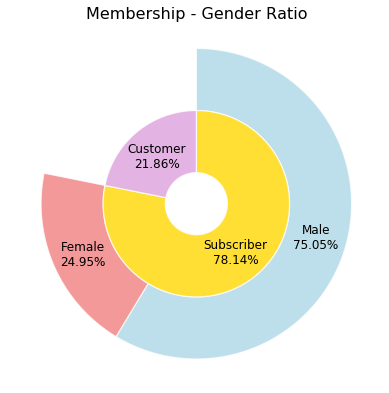

In [15]:
# Nested Doughnut Plot:  
# Membership Gender Ratio

user_num = sum(user_sizes)
member_num = sum(gender_sizes)

member_gender_Ratio = [('All Users', 100,
                        [(user_labels[0], Rate(user_sizes[0], user_num),
                          [(gender_labels[0], Rate(gender_sizes[0], user_num), []),
                           (gender_labels[1], Rate(gender_sizes[1], user_num), []),
                          ]),
                         (user_labels[1], Rate(user_sizes[1], user_num), []),
                        ]),
                      ]

ratio = {user_labels[0]: str(Rate(user_sizes[0], user_num),),
         user_labels[1]: str(Rate(user_sizes[1], user_num)), 
         gender_labels[0]: str(Rate(gender_sizes[0], member_num)),
         gender_labels[1]: str(Rate(gender_sizes[1], member_num))
        }

Sunburst(member_gender_Ratio, ratio)


The above sunburst plot display display the proportion of all categories of user types at a tme.
- All users 100%:
    - Subscriber: 78.14%
        - Female: 24.95%
        - Male: 75.05%
    - Customer: 21.86%

### Exploring Trips over Time

First of all, look at the trend of year-round daily number of usage in 2017.

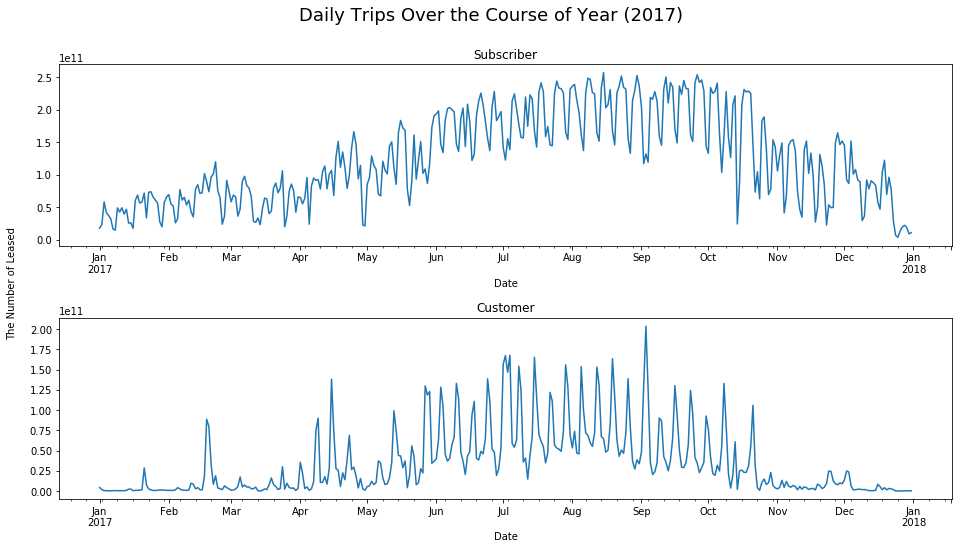

In [26]:
# Line Plot: 
# Year-round Usage Performance in 2017

ind = pd.DatetimeIndex(TripDataset.StartTime)
TripDataset['Date'] = ind.date.astype('datetime64')
TripDataset['Hour'] = ind.hour

# count trips by date separate by user type 
by_date = pd.pivot_table(TripDataset, 'TripID', index='Date',
                         aggfunc=np.sum, columns='UserType')\
            .dropna(axis=1)


fig, ax = plt.subplots(2, figsize=(16, 8))

fig.subplots_adjust(hspace=0.4)
fig.text(0.08, 0.5, 'The Number of Leased', va='center', rotation='vertical', fontsize=10)

by_date.iloc[:, 0].plot(ax=ax[1], title='Customer',)
by_date.iloc[:, 1].plot(ax=ax[0], title='Subscriber')

plt.suptitle("Daily Trips Over the Course of Year (2017)", fontsize=18)
plt.show()

This plot displays the daily trend, separated by registered members (top) and one-off customer (bottom). The following  characteristics can be given in the plot:

* Since mid-May, the number of shared bicycles usage has been on the rise and this trend continued until the end of September, both for members and non-members.
* There exists a __steady ebb and flow with the seasons__ for all users. But this feature of one-off costomer is even more compelling.
* Both 'Subscribe' members and one-off customer seem to show a distinct __weekly trend__.

In order to further confirm the first and second features summarized above, construct a 'Calender Heatmap', which illustrates the relationship between the number of leased of bike and season(month) in a year. 

In [27]:
# Calender Heatmap(Interactive):
# Total Number of Seasonal Bike Rentals

# count trips by date
calender = pd.pivot_table(TripDataset, 'TripID', index='Date', 
                          aggfunc=np.sum).reset_index()

calender.Date = calender.Date.astype(str)

heatmap = pyecharts.HeatMap("Total Number of Leased of Bike", "Calender Heatmap", width=1000)
heatmap.add(
    "",
    calender.values.tolist(),
    is_calendar_heatmap=True,
    visual_text_color="#000",
    visual_range_text=["Min", "Mix"],
    visual_range=[min(calender.TripID), max(calender.TripID)],
    calendar_cell_size=["auto", 30],
    is_visualmap=True,
    calendar_date_range="2017",
    visual_orient="horizontal",
    visual_pos="center",
    visual_top="80%",
    is_piecewise=False)
heatmap.render("yearlyHeatmap.html")
heatmap

**[<font color=red>Click to see the Yearly Bike Usage Heatmap</font>](yearlyHeatmap.html)**

Above is an _interactive map_. Adjust the leftmost cursor of the legend to the middle, partial data cells in May and October and almost all data cells from June to September are highlighted in warm color. Restore the left cursor to the leftmost position, then drag the rightmost cursor to the middle. Thereupon, the rest data cells in May and October and almost all data cells from November to April are highlighted in cold color. The redder the color, the more times the lease is made on this day, and the more blue, the less.

These facts give the information that summer cyclists are more than winter and demonstrate that __the number of bicycle rentals is seasonal__.

Regarding the third feature, zoom in on the weekly trend and build an interactive line graph. 

- _The dash line corresponds to the average value respectively._
- _Placing the cursor on any node on the lines will show the specific value of that node._
- _Clicking on the legend will display/hide the corresponding line._

In [30]:
# Line Plot(Interactive): 
# Total Number of Bike Usage by Day of Week (2017)

by_weekday = by_date.groupby(by_date.index.dayofweek).sum()
by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

line = pyecharts.Line("Total Number of Bike Usage by Day of Week (2017)", title_pos='center')

for user in user_labels:
    v = by_weekday[user]/(10**9)
    
    line.add(user, 
             by_weekday.index.tolist(), 
             v.tolist(), 
             mark_line=["average"],
             legend_pos="right", 
             legend_orient="vertical",
             yaxis_name='The Number of Leased (in billion)',
             yaxis_name_gap=50
            )
line.render("DayofWeek.html")
line

**[<font color=red>Click to see the Total Number of Bike Usage by Day of Week (2017)</font>](DayofWeek.html)**

Obviously, a complementary pattern overall appears: subscribers tend to use the bikes during Monday to Friday (i.e as part of a commute) while one-off customers trnd to use the bikes on the weekend.

Now, take a closer look at the total number of bike rented per hour by week. Before counting trips by day of week, it is necessary to convert the date to the corresponding day of the week by using `dt.day_name()` and then to observe the hourly trends among the days within each day of week:

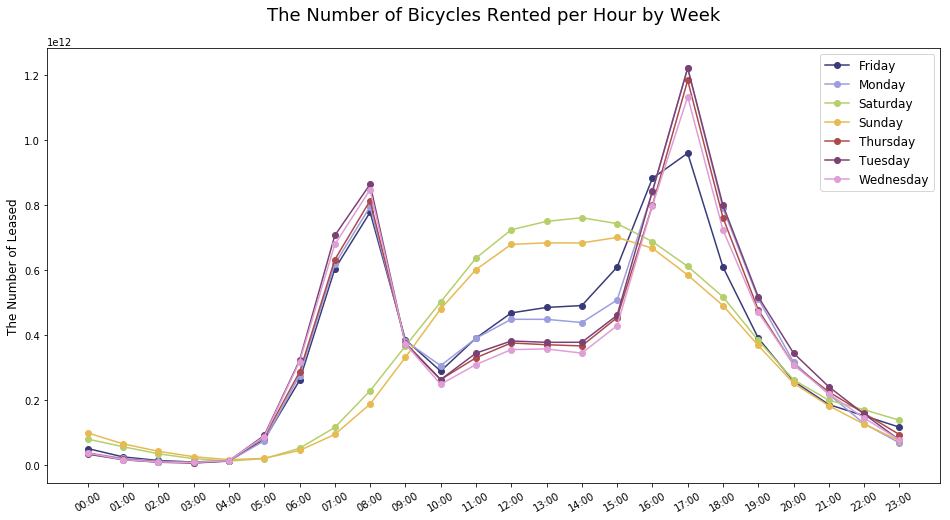

In [31]:
# Line Plot: 
# Total number of bike rented per hour by week

# map date into day of week
TripDataset['Day_Of_Week'] = TripDataset['Date'].dt.day_name() 

# count trips by day of week
by_dayofweek = pd.pivot_table(TripDataset, values='TripID', index=['Hour'],
                              aggfunc=np.sum, columns='Day_Of_Week')\
                 .fillna(0).reset_index('Hour').drop(['Hour'], axis=1)

# x ticks label
hours = ['{:02d}:00'.format(hr) for hr in range(24)] 
fig, ax = plt.subplots(figsize=(16, 8))

by_dayofweek.plot(marker='o', colormap='tab20b', ax=ax)

plt.legend(frameon=True, facecolor='white', fontsize='large')
plt.xticks(range(24), hours, rotation=30)

plt.title("The Number of Bicycles Rented per Hour by Week", fontsize=18, y=1.05)
plt.ylabel('The Number of Leased', fontsize=12)

plt.show()

Two distinct patterns grouped by weekday and weekend emerge from the line plot above. The first pattern, named as 'commute' mode, illustrates a sharp bimodal traffic pattern, around 8:00am and 5:00pm, while the other pattern is named as 'recreational' mode that gives a wide unimodal pattern whose peak is areound 2pm.

Therefore, for the purpose of better summarizing the behavioral differences between members and non-members, decompose the above diagram into two parts by day of week.

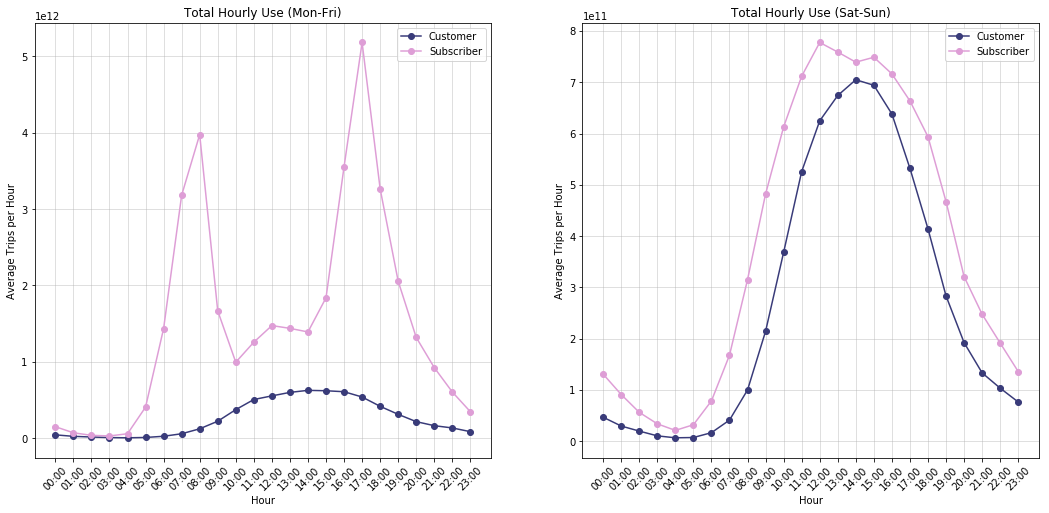

In [32]:
# Line Plot:
# Total Hourly Use (Mon-Fri) / (Sat-Sun)

# count trips by date and by hour
by_hour = pd.pivot_table(TripDataset, 'TripID', index=['Date', 'Hour'],
                         aggfunc=np.sum, columns='UserType')\
            .fillna(0).reset_index('Hour')

# distinguish weekday and weekend
by_hour['Weekend'] = (by_hour.index.dayofweek >= 5)

by_hour = by_hour.groupby(['Weekend', 'Hour']).sum()
by_hour.index.set_levels([['Weekday', 'Weekend'], 
                          ["{0}:00".format(i) for i in range(24)]], 
                         inplace=True)
by_hour.columns.name = None # remove label for plot


fig, ax = plt.subplots(1, 2, figsize=(18, 8))

by_hour.loc['Weekday'].plot(title='Total Hourly Use (Mon-Fri)', 
                            ax=ax[0], marker='o', colormap='tab20b')
by_hour.loc['Weekend'].plot(title='Total Hourly Use (Sat-Sun)', 
                            ax=ax[1], marker='o', colormap='tab20b')
for axi in ax:
    axi.grid(True, alpha=0.5)
    axi.set_xticks(range(24))
    axi.set_xticklabels(hours, rotation=45)
    axi.set_ylabel('Average Trips per Hour')

plt.show()

The characteristics of this diagram complement the "The Number of Bicycles Rented per Hour by Week" plot. It is confirmed that subscribers are more willing to use bicycles during working hours on weekdays. However, the behavior of subscribers seems to be almost identical to the behavior of one-off customers on weekend.

### Trip Duriations

Next, draw a density distribution of the duration of the trips to figure out the relationship between the trip duriations and user type.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


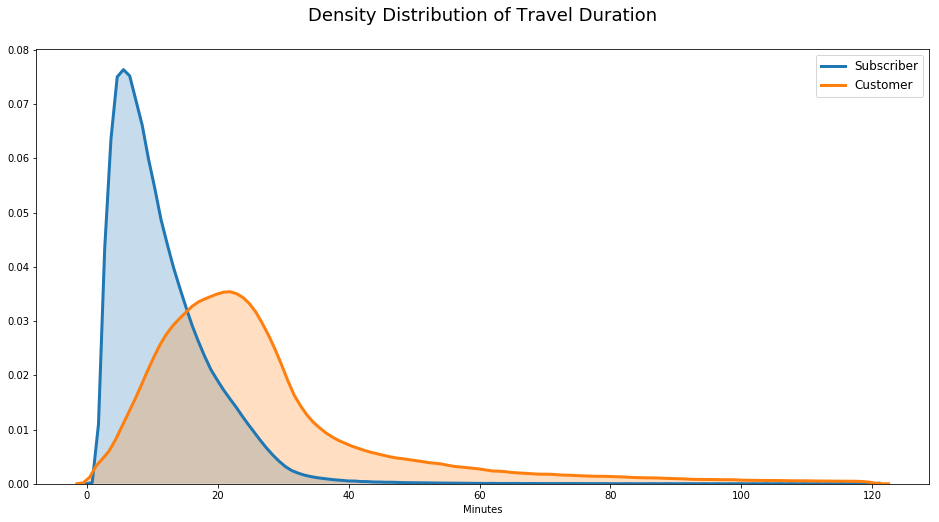

In [33]:
# Trip Duration

TripDataset['Minutes'] = TripDataset.TripDuration/60

fig, ax = plt.subplots(figsize=(16,8))

for member in user_labels:
    subset = TripDataset[(TripDataset['UserType'] == member)&(TripDataset['Minutes'] < 120)]
    sns.distplot(subset['Minutes'], hist = False, kde = True, 
                 kde_kws = {'shade': True, 'linewidth': 3}, label=member)
plt.legend(frameon=True, facecolor='white', fontsize='large')
plt.title("Density Distribution of Travel Duration", fontsize=18, y=1.05)

plt.show()

Two important pieces of information can be extracted from the above plot:

- The number of members who spend about 5 to 20 minutes on bicycles accounts for a large part which makes sense that it takes about 20 minutes by bike from home to the workplace. As mentioned earlier, subscribers are willing to use bicycles as commuting tools for commuting to and from work.
- The average length of time for ordinary users to ride bicycles is longer than that of members.

### Analysis Base on Stations

In [34]:
# count trips by start and end stations
by_station = TripDataset.groupby(by=["FromStationID", "FromStation", "ToStationID", "ToStation"])\
                        .size().reset_index(name='Times')
by_station.sort_values(by=["Times"], inplace=True)

Filter out the relatively not popular routes before analysising because of the vast amount of routes between to stations during a year. Construct a heatmap which displays the relationship between the departure stations and arrival station:

In [35]:
# filter out the less popular routes
top_station = by_station[by_station["Times"] >= 1500]
StationPair = pd.DataFrame({'FromStation': list(top_station.FromStation) + list(top_station.ToStation),
                             'ToStation': list(top_station.ToStation) + list(top_station.FromStation),
                             'Counts': list(top_station.Times) * 2
                            })

StationPair_df = pd.pivot_table(StationPair, index='FromStation', columns='ToStation', aggfunc=np.sum)
StationPair_df.columns = StationPair_df.Counts.columns


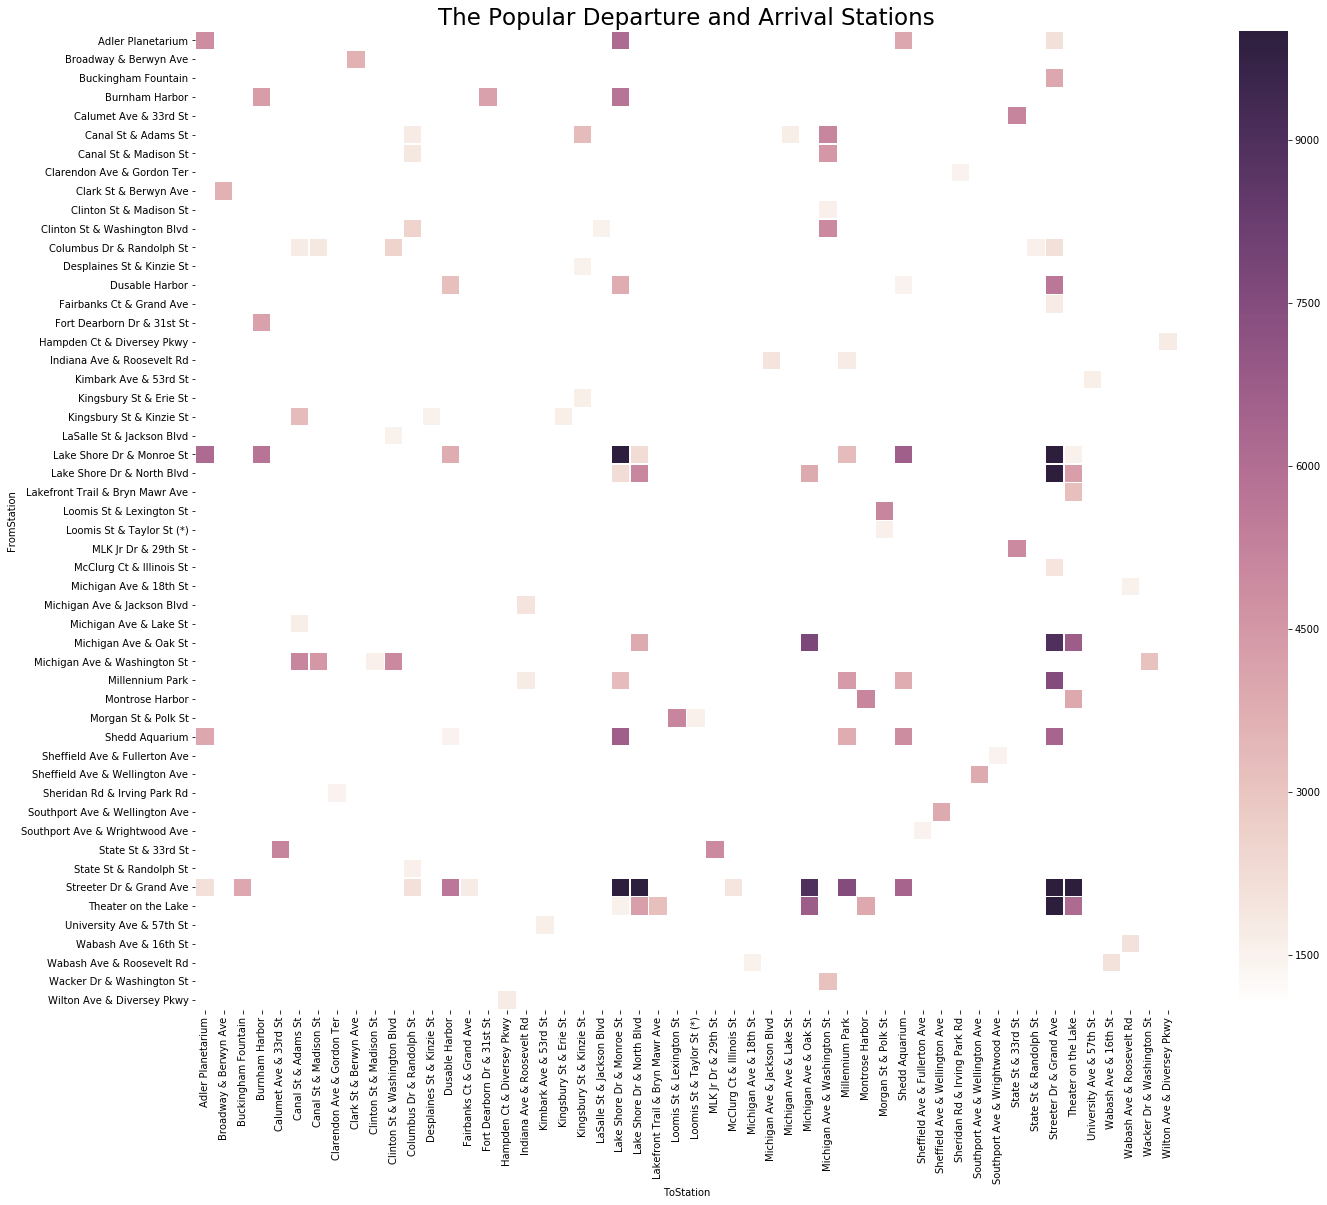

In [36]:
# Heatmap:
# Popular departure and arrival stations

fig, ax = plt.subplots(figsize=(22, 18))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(StationPair_df.fillna(0), linewidths=0.5, ax=ax, vmax=10000, vmin=1000, 
            cmap=cmap, xticklabels=True, yticklabels=True)
ax.set_title("The Popular Departure and Arrival Stations", fontsize=23, y=1.05)

plt.plot();

The darker the color, the stronger the relationship between the two stations, which means that the route is more popular. Hence, there are 6 routes which had been used the most frequently in 2017 shown by the heatmap above.

| Station 1 | Station 2 |
| ------------- |:-------------:|
| Lake shore Dr & Monrone St | Lake shore Dr & Monrone St |
| Lake shore Dr & Monrone St | Streeter Dr & Grand Ave |
| Streeter Dr & Grand Ave | Michigan Ave & Oak St |
| Streeter Dr & Grand Ave | Lake Shore Dr & North Blvd |
| Streeter Dr & Grand Ave | Thearter on the Lake |
| Thearter on the Lake | Thearter on the Lake |

If the Station 1 is same as the Station 2, this means that the same station for picking-up and drop off a bike.

### Stations and Routes Distribution Map

Draw a map in order to give a more intuitively image of and more general information of the station distribution and route map of shared bicycles in Chicago.

In [37]:
station_latlon = pd.DataFrame(Station_df, columns=['ID', 'Name', "Latitude", "Longitude"])

# map latitude and longitude to each route
from2Station = pd.merge(by_station[by_station["Times"] >= 1000], 
                        station_latlon, 
                        left_on=['FromStationID', 'FromStation'], 
                        right_on=['ID', 'Name'], 
                        how='inner')

from2Station = pd.merge(from2Station.drop(['ID', 'Name'], axis=1).drop_duplicates(), 
                        station_latlon,
                        left_on=['ToStationID', 'ToStation'],
                        right_on=['ID', 'Name'], 
                        how='inner')

from2Station = from2Station.drop(['ID', 'Name'], axis=1).drop_duplicates()

The following [Chicago dock map](Chicago.html) shows that the users live close to the downtown and the center of Chicago are more active than the others. Therefore, the company settled more bike statoions around these area. (_Only part of the routes displayed on the map which are relatively popular._)

- __Map Instruction__:
    - Legend:
        - Switch map theme:
            - 'openstreetmap': display more detail on the map, 
            - 'cartodbdark_matter': display less detail on the map but can display the routes clearer
        - Station Icons: Show or hide the station icons on the map.
        - Routes: Show or hide the routes.
    - Prevalence Level of routes：
        - red line: very popular
        - green line: median popular
        - yellow line: less popular
    - Click any station icon will pop up the detail of the corresponding station.
    - Click any routes(lines) will pop up the number of this route usage

In [38]:
cw = {'high':['red',6], 'med':['green',4], 'low':['yellow',2]}
low, high = np.percentile(from2Station.Times, [78, 96.5])

Chicago = folium.Map(location=[latAvg, lonAvg+0.01], zoom_start=12.5)
Chicago.add_tile_layer() 
folium.TileLayer('CartoDB dark_matter').add_to(Chicago)

StationFeature = folium.FeatureGroup(name='Station Icon')
RouteFeature = folium.FeatureGroup(name='Routes')
StationIcon = MarkerCluster()
RouteLine = MarkerCluster()

for index, station in Station_df.iterrows(): 
    
    text = folium.Html('<b>Station ID: {}</b></br> <b>Name: {}</b></br> <b>Dpcapacity: {}</b></br> '\
                       .format(station['ID'], station['Name'], station['Dpcapacity']), script=True)
    popup = folium.Popup(text, max_width=2650)

    StationIcon.add_child(folium.Marker(location=[station["Latitude"], station["Longitude"]],
                                        popup=popup,
                                        icon=folium.Icon(color='red', 
                                                         icon_color='white', 
                                                         icon='bicycle', 
                                                         angle=0, 
                                                         prefix='fa')))

for index, route in from2Station.iterrows():
    
    text = folium.Html('<b>Times: {}</b></br>'.format(route['Times']), script=True)
    popup = folium.Popup(text, max_width=2650)
    
    level = 'low'
    if route['Times'] > high: level = 'high'
    elif route['Times'] > low: level = 'med'
                    
    RouteLine.add_child(folium.PolyLine(locations=[[route['Latitude_x'], route['Longitude_x']],
                                                   [route['Latitude_y'], route['Longitude_y']]],
                                        popup=popup, 
                                        color=cw[level][0], 
                                        weight=cw[level][1]))

StationFeature.add_child(StationIcon)
Chicago.add_child(StationFeature)

RouteFeature.add_child(RouteLine)
Chicago.add_child(RouteFeature)

folium.LayerControl(collapsed=False).add_to(Chicago)
Chicago.save('Chicago.html')
display(Chicago)

[The heatmap of the number of the dock in Chicago](dockNum_heatmap.html) below is a supplement to the previous map. The redder the color, the more stations and docks around this area, and the more blue, the less. The most significant infornation can be extracted from these two map is there are more stations, docks, and the larger number of activities for renting bicycles around the downtown Chicago.

In [42]:
dockNum = folium.Map(location=[latAvg, lonAvg], zoom_start=12)

dock_num = pd.DataFrame(Station_df, columns=["Latitude", "Longitude", "Dpcapacity"])
dock_num = dock_num.values.tolist()
dockNum_heatmap = dockNum.add_child(HeatMap(data=dock_num, radius=13))

dockNum_heatmap.save("dockNum_heatmap.html")
dockNum_heatmap

### Pairwies Correlation

Think of the relationship between some worth considering variables with the number of trips. However, the type of some unordered categorical variables is `str`, such as 'UserType' and 'Gender'. It is necessary to generate a mapping of gender and user type. Then transform gender and usertype to a number representation. This takes a bit of manipulation:

In [28]:
bike = pd.merge(TripDataset, from2Station, 
                   on=['FromStationID', 'FromStation', 'ToStationID', 'ToStation'], 
                   how='inner')

# convert unordered string variable into numerical variable
convert = {'UserType': {'Subscriber':0, 'Customer':1},
           'Gender': {'Male':0, 'Female':1}}

for col, sub in convert.items():
    for key, val in sub.items():
        bike.loc[bike[col]==key,col] = val

In [29]:
# calculate the pairwise correlation 
Correlation = bike[['Times', 'UserType', 'Day_Of_Week', 'Minutes',
                    'Latitude_x','Longitude_x', 'Latitude_y','Longitude_y']].corr()
Correlation

,Times,UserType,Minutes,Latitude_x,Longitude_x,Latitude_y,Longitude_y
Times,1.000000,0.340276,0.141573,-0.040116,0.320416,0.010120,0.326022
UserType,0.340276,1.000000,0.408525,-0.050962,0.504961,-0.040280,0.514283
Minutes,0.141573,0.408525,1.000000,0.012242,0.239447,0.020873,0.244063
Latitude_x,-0.040116,-0.050962,0.012242,1.000000,-0.569410,0.889880,-0.524543
Longitude_x,0.320416,0.504961,0.239447,-0.569410,1.000000,-0.504027,0.839684
Latitude_y,0.010120,-0.040280,0.020873,0.889880,-0.504027,1.000000,-0.558286
Longitude_y,0.326022,0.514283,0.244063,-0.524543,0.839684,-0.558286,1.000000


Get some conclusions by observing the generated pairwise correlation table:

- Relatively strong positive correlation(>0.3) between Times and UserType, Longitude_x, Longitude_y:
    - Times and UserType:
        More trips comes from the subscribers.
    - Times and Longitude_x:
        The departure station at high latitude will generate more journeys.
    - Times and Longitude_y:
        The arrival station at high latitude will generate more journeys.
- Weak correlation between Times and Minutes, Latitude_x, Latitude_y:
    - This means that there is no correlation between Times and Minutes, Latitude_x, Latitude_y.

Intuitivly display the pairwise correlation between each variables via heatmap.
- Warm tones indicate positive correlation
- Cold tones indicate negative correlation

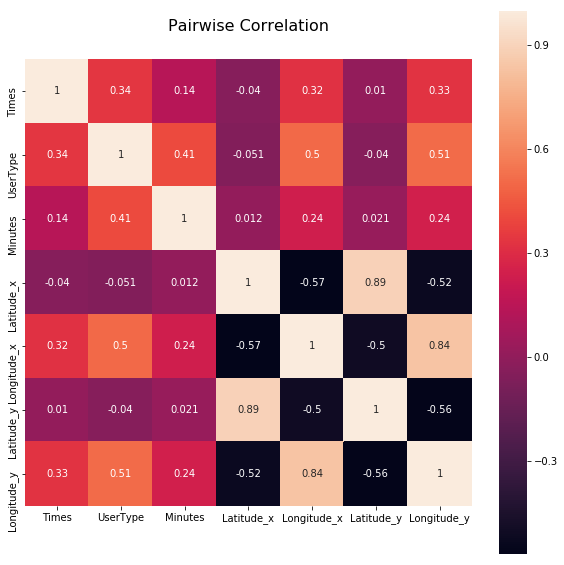

In [30]:
# Heatmap:
# Pairwise Correlation
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(Correlation, square=True, annot=True)
ax.set_title("Pairwise Correlation", fontsize=16, y=1.05)
plt.show()

## Summary

There are several main takeaway points that can learn from this look at the data:

- The majority of users are subscribers, and the proportion of subscriber is dominated by male.

- There exists a steady ebb and flow with the seasons for all users.
    _If know which season the users are using the bikes, then can make more bike avaliable during that month._

- Registered Subscribers and one-off customers show markedly different behavior in aggregate: 
    - Annual subscribers seem to use the bike mostly for commuting on weekdays, while one-off customers use the bike primarily on weekends to explore particular areas of Chicago.
        _Identify the peak times allows to allocate the biek from less popular station to the popular stations during the peak times_
   
   - The trip duriations of the scribers are most in \[5, 20\] minutes, while The average length of time for ordinary users to ride bicycles is longer than that of annual members, the range is around \[10,30\] minutes.
       _Long bike trip caouse less avaliabe bike for the others._

- Bicycle rental activities are mostly happen in the downtown. So that more bikes should be prepared.